In [6]:
!pip install mlxtend


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import pandas as pd

# Load data from local CSV files
orders = pd.read_csv('Machine learning/order.csv')
trees = pd.read_csv('Machine learning/treez.csv.csv', low_memory=False)
print('Orders preview:')
print(orders.head())
print('\nTrees preview:')
print(trees.head())

Orders preview:
   ORDER_ID    COMMON_NAME
0         3      Grevillea
1         3   Deodar cedar
2         3  Texas red oak
3         3  Austrian pine
4         3   London Plane

Trees preview:
  most_recent_observation most_recent_observation_type  common_name  \
0               6/17/2020               inventory_date       Locust   
1              06/09/2020               inventory_date          Oak   
2              06/03/2020               inventory_date          Ash   
3              06/03/2020               inventory_date  Scotch pine   
4               5/29/2020               inventory_date  Honeylocust   

         scientific_name         city       state  longitude_coordinate  \
0                    NaN  Albuquerque  New Mexico           -106.568366   
1                Quercus  Albuquerque  New Mexico           -106.655037   
2               Fraxinus  Albuquerque  New Mexico           -106.581127   
3       Pinus sylvestris  Albuquerque  New Mexico           -106.575056   
4  G

In [11]:
import re

def normalize_name(s):
    if pd.isna(s): return ""
    return re.sub(r"[^\w\s]", "", str(s).lower().strip())

kaggle_common_col = [c for c in trees.columns if "common" in c.lower()][0]

trees["common_norm"] = trees[kaggle_common_col].apply(normalize_name)
orders["common_norm"] = orders["COMMON_NAME"].apply(normalize_name)

valid_names = set(trees["common_norm"])
orders = orders[orders["common_norm"].isin(valid_names)]

print("✅ Filtered orders:", len(orders))
print(orders.head())

✅ Filtered orders: 20
   ORDER_ID    COMMON_NAME    common_norm
1         3   Deodar cedar   deodar cedar
2         3  Texas red oak  texas red oak
3         3  Austrian pine  austrian pine
4         3   London Plane   london plane
5         4   Siberian elm   siberian elm


In [12]:
transactions = orders.groupby("ORDER_ID")["common_norm"].apply(list).tolist()
print("Sample transaction baskets:")
for t in transactions[:5]:
    print(t)

Sample transaction baskets:
['deodar cedar', 'texas red oak', 'austrian pine', 'london plane']
['siberian elm', 'crabapple', 'desert willow']
['crabapple']
['crabapple', 'austrian pine', 'siberian elm', 'cottonwood', 'deodar cedar', 'bur oak', 'texas red oak']
['bur oak', 'deodar cedar', 'desert willow', 'texas red oak', 'crabapple']


In [13]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules


te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_enc = pd.DataFrame(te_ary, columns=te.columns_)

# Apriori
frequent_itemsets = apriori(df_enc, min_support=0.2, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

strong_rules = rules[(rules["confidence"] >= 0.7) & (rules["lift"] > 1)]
print("✅ Strong rules found:", len(strong_rules))
print(strong_rules[["antecedents","consequents","support","confidence","lift"]].head(10))


✅ Strong rules found: 1291
        antecedents      consequents  support  confidence      lift
3      (cottonwood)  (austrian pine)      0.2         1.0  2.500000
5   (austrian pine)   (deodar cedar)      0.4         1.0  1.666667
7    (london plane)  (austrian pine)      0.2         1.0  2.500000
12  (austrian pine)  (texas red oak)      0.4         1.0  1.666667
13     (cottonwood)        (bur oak)      0.2         1.0  2.500000
16        (bur oak)      (crabapple)      0.4         1.0  1.250000
18        (bur oak)   (deodar cedar)      0.4         1.0  1.666667
24        (bur oak)  (texas red oak)      0.4         1.0  1.666667
25     (cottonwood)      (crabapple)      0.2         1.0  1.250000
26     (cottonwood)   (deodar cedar)      0.2         1.0  1.666667


In [15]:
def recommend(tree, rules_df=strong_rules, top_n=5):
    recs = rules_df[rules_df['antecedents'].apply(lambda x: tree in x)]
    if recs.empty:
        print(f"No recommendations for {tree}")
        return
    recs = recs.sort_values(by=["confidence","lift"], ascending=False)
    for _, r in recs.head(top_n).iterrows():
        print(f"💡 If buyer gets {list(r['antecedents'])} → recommend {list(r['consequents'])} "
              f"(conf={r['confidence']:.2f}, lift={r['lift']:.2f})")

# for instance
recommend("crabapple")


💡 If buyer gets ['austrian pine', 'crabapple'] → recommend ['cottonwood'] (conf=1.00, lift=5.00)
💡 If buyer gets ['austrian pine', 'crabapple', 'bur oak'] → recommend ['cottonwood'] (conf=1.00, lift=5.00)
💡 If buyer gets ['austrian pine', 'crabapple'] → recommend ['cottonwood', 'bur oak'] (conf=1.00, lift=5.00)
💡 If buyer gets ['cottonwood', 'crabapple'] → recommend ['austrian pine', 'bur oak'] (conf=1.00, lift=5.00)
💡 If buyer gets ['austrian pine', 'crabapple'] → recommend ['siberian elm', 'bur oak'] (conf=1.00, lift=5.00)


C:\Users\user\AppData\Local\Temp\ipykernel_16204\4213604927.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=most_common.values, y=most_common.index, palette='viridis')


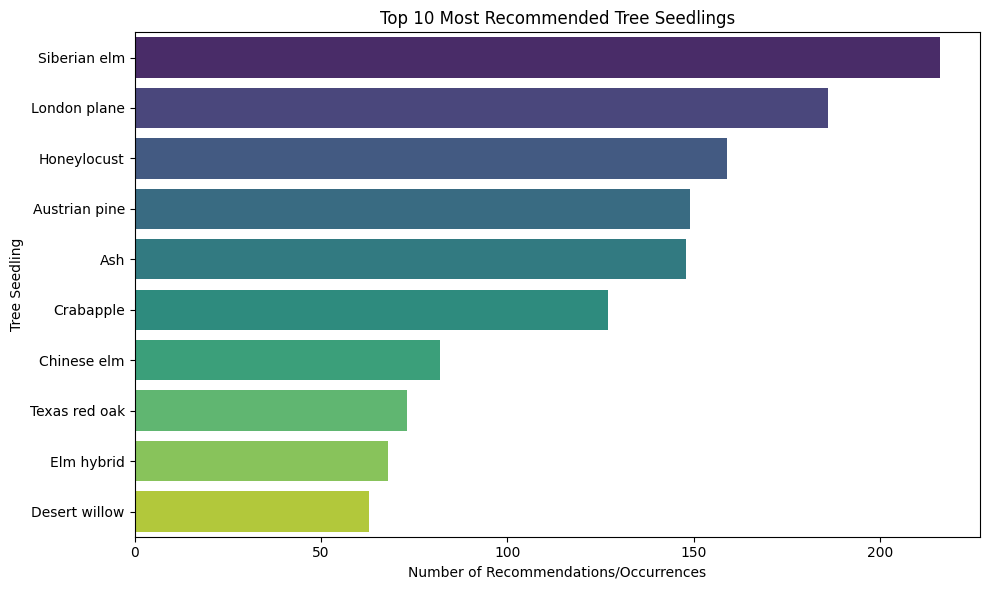

Key Insights:
- The most recommended tree seedling is: Siberian elm (216 times).
- The top 3 are: Siberian elm, London plane, Honeylocust.
- There are 101 unique tree species in the data.


In [1]:
# EDA: Most Recommended Tree Seedlings (Key Insights)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data (adjust path if needed)
df = pd.read_csv('Machine learning/treez.csv.csv')

# Analyze the most frequent (recommended/purchased) tree seedlings
# Here, we use 'common_name' as the key column
most_common = df['common_name'].value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=most_common.values, y=most_common.index, palette='viridis')
plt.title('Top 10 Most Recommended Tree Seedlings')
plt.xlabel('Number of Recommendations/Occurrences')
plt.ylabel('Tree Seedling')
plt.tight_layout()
plt.show()

# Key insights
print('Key Insights:')
print(f"- The most recommended tree seedling is: {most_common.index[0]} ({most_common.iloc[0]} times).")
print(f"- The top 3 are: {', '.join(most_common.index[:3])}.")
print(f"- There are {df['common_name'].nunique()} unique tree species in the data.")

In [ ]:
# Pie chart: Most Selling Tree Seedlings
import matplotlib.pyplot as plt

# Assuming 'orders' DataFrame has a 'common_name' or similar column for sold seedlings
sold_counts = orders['common_norm'].value_counts().head(10)

plt.figure(figsize=(8,8))
plt.pie(sold_counts.values, labels=sold_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.viridis.colors[:10])
plt.title('Top 10 Most Selling Tree Seedlings')
plt.axis('equal')
plt.show()

# Bar chart: Seller Recommendation Strength for a Searched Seedling
# Example: show top recommended seedlings for a given seedling using association rules
searched_seedling = 'crabapple'  # Change this to test other seedlings

recs = strong_rules[strong_rules['antecedents'].apply(lambda x: searched_seedling in x)]
if not recs.empty:
    top_recs = recs.sort_values(by=['confidence','lift'], ascending=False).head(10)
    plt.figure(figsize=(10,6))
    plt.barh([', '.join(map(str, c)) for c in top_recs['consequents']], top_recs['confidence'], color='teal')
    plt.xlabel('Recommendation Confidence')
    plt.title(f'Top Recommendations if Buyer Gets "{searched_seedling.title()}"')
    plt.gca().invert_yaxis()
    plt.show()
else:
    print(f'No recommendations found for {searched_seedling}.')